In [1]:
from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import itertools
import numbers
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod
from warnings import warn
from sklearn.metrics import confusion_matrix

data = sio.loadmat('face.mat')
face_data=data['X']
c=data['l']

num_img = face_data.shape[1] # num_img=520
num_pix = face_data.shape[0]

# split into train and test sets
img_idx_train = []
img_idx_test = []
true_idx_train = []
true_idx_test = []
for i in range(num_img):
    if i%10>7: #train: test = 8:2
        img_idx_test.append(i)
    else:
        img_idx_train.append(i)

img_train = np.delete(face_data, img_idx_test, 1) # 2576*img_train.shape[1]        
img_test = np.delete(face_data, img_idx_train, 1) # 2576*img_test.shape[1]
true_idx_test = np.delete(c, img_idx_train, 1)
img_mean = img_train.mean(axis=1)
img_norm = img_train - img_train.mean(axis=1)[:,None] # img_norm is 2576*img_train.shape[1]
img_mean_test = img_test.mean(axis=1)
img_norm_test = img_test - img_mean_test[:,None] # img_norm_test is 2576*img_test.shape[1]
num_test = img_test.shape[1]

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    #plt.xticks(xlocations, labels, rotation=90)
    #plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class bagging:
    def __init__(self, random_state, bootstrap_features,
                       bootstrap_samples, n_features, n_samples,
                       max_features, max_samples):
        self.random_state = check_random_state(random_state) # random state controls shuffling
        self.bootstrap_features = bootstrap_features # features array input 
        self.bootstrap_samples = bootstrap_samples # samples array input
        self.n_features = n_features # maximum index of features that we could range
        self.n_samples = n_samples # maximum index of samples that we could range(i.e. 520)
        self.max_features = max_features # maximum number of features per bag
        self.max_samples = max_samples # maximum number of samples per bag
        
    def _generate_bagging_indices(self):
        """Randomly draw feature and sample indices."""
        # Get valid random state
        # random_state = check_random_state(random_state)
        # Draw indices
        feature_indices = self._generate_indices(self.bootstrap_features, self.n_features, self.max_features)
        sample_indices = self._generate_indices(self.bootstrap_samples, self.n_samples, self.max_samples)
        return feature_indices, sample_indices
    
    def _generate_indices(self, bootstrap, n_population, n_samples):
        """Draw randomly sampled indices."""
        indices = self.random_state.randint(0, n_population, n_samples)
        return indices

class PCA_LDA:
    def __init__(self, idx_train, true_lable):    
        #training set
        self.img_train = face_data[:,idx_train]
        self.img_mean = self.img_train.mean(axis=1)
        self.img_norm = self.img_train - self.img_mean[:,None] # img_norm is 2576*img_train.shape[1]
        self.train_size = self.img_norm.shape[1]
        self.num_pix = 2576
        self.true_lable = true_lable
        self.distinct_class = np.unique(self.true_lable)
        self.num_class = self.distinct_class.shape[0]
    
    def _opt_components(self):
        img_mean = self.img_mean.reshape(2576, 1)
        # PCA dimension reduction
        S=np.divide(np.matmul(self.img_norm.T,self.img_norm),self.train_size)
        eigval, eigvec = np.linalg.eig(S)
        # sort eigvals in descending order
        idx = eigval.argsort()[::-1]   
        eigval = eigval[idx]
        eigvec = eigvec[:,idx]
        eigvec = np.matmul(self.img_norm,eigvec) 
        eigvec = preprocessing.normalize(eigvec, norm='l2', axis=0)

        # LDA  
        train_temp = []
        class_mean=np.zeros((self.num_pix, self.num_class))

        self.distinct_class = self.distinct_class.ravel()
        for i in range(self.num_class):
            idx_find = self.distinct_class[i]
            temp_idx = np.where(self.true_lable == idx_find)[1]

            temp_class = self.img_train[:,temp_idx]
            train_temp.append(temp_class)
            
            class_mean[:,i]=temp_class.mean(axis=1)
            
        class_mean_split = np.split(class_mean, self.num_class, axis = 1)    
        # compte S_b
        S_b=np.zeros((num_pix,num_pix))
        
        for i in range(self.num_class):
            mean_vec = class_mean_split[i].reshape(2576, 1)
            S_b +=  np.dot((mean_vec-img_mean),(mean_vec-img_mean).T)
            
        # compute S_w
        del mean_vec  
        S_w=np.zeros((num_pix,num_pix))
        for i in range(self.num_class):
            scatter_w = train_temp[i] - np.squeeze(class_mean_split[i])[:,None]
            S_w += np.matmul(scatter_w,scatter_w.T)       
        # recogiton for fixed M_pca and M_lda
        
        M_pca=160
        M_lda=40 # survey up to M_lda
        
        W_pca=eigvec[:,:M_pca]
        # compute generalized eigvecs and eigvals
        temp = np.matmul((np.linalg.pinv(np.matmul(np.matmul(W_pca.T,S_w),W_pca))), (np.matmul(np.matmul(W_pca.T,S_b),W_pca)))

        # sort eigvals and eigvecs in descending order
        eigvals_gen, eigvecs_gen = np.linalg.eig(temp)
        idx_gen = eigvals_gen.argsort()[::-1]   
        eigvals_gen = eigvals_gen[idx_gen]
        eigvecs_gen = eigvecs_gen[:,idx_gen]      
        W_lda=eigvecs_gen[:,:M_lda]
        W_opt=np.matmul(W_pca,W_lda)
        return W_opt 

class recognition:
    def __init__(self, W_opt, img_norm, img_test):
        self.W_opt = W_opt
        self.img_norm = img_norm
        self.img_mean_test = img_test.mean(axis=1)
        self.img_norm_test = img_test - self.img_mean_test[:,None] 
        self.prediction = []
        
    def _index(self):
        w_n = np.matmul(self.img_norm.T, self.W_opt)        
        w = np.matmul(self.img_norm_test.T, self.W_opt)
        e_NN = np.zeros((self.img_norm.shape[1],1))
        
        for i in range(self.img_norm_test.shape[1]):          
            for j in range(self.img_norm.shape[1]):
                e_NN[j] = np.linalg.norm(w[i,:]-w_n[j,:])
            idx_val = np.argmin(e_NN) # the index in train set as per img_train.shape[1] train images
            id_pred = int(img_idx_train[idx_val]/10)+1 # predicted label
            self.prediction.append(id_pred)
        return  self.prediction
    
class ensemle:   
    def _committee_score(pred, true_idx):
        return 1-np.count_nonzero(np.asarray(pred) - true_idx)/true_idx.shape[1]
    
    def _majority_vote(predictions):
        vote = []
        result = []
        for j in range(num_test):
            for i in range(len(predictions)):
                vote.append(predictions[i][j])
            _vote = np.asarray(vote)    
            counts = np.bincount(vote)
            result.append(np.argmax(counts))
            vote.clear()
        return result

def plot_img(img2plot):
    img2plot = np.reshape(img2plot,(46,56)).T
    plt.imshow(img2plot, cmap = 'gist_gray')
    
def PCA_only(img_norm, M_reserve):
    S=np.divide(np.matmul(img_norm.T,img_norm),img_norm.shape[1])
    eigval, eigvec = np.linalg.eig(S)
    idx = eigval.argsort()[::-1]   
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    eigvec_pseudo = np.matmul(img_norm,eigvec) 
    eigvec_pseudo = preprocessing.normalize(eigvec_pseudo, norm='l2', axis=0) # axis = 0, normalise each feature
    #eigvec = eigvec_pseudo[~np.all(eigvec_pseudo == 0, axis=1)] #N-1 eigen_vectors are retained
    eigvec_major = eigvec_pseudo[:,:M_reserve]
    eigvec_residual = eigvec_pseudo[:,M_reserve:]
    #del eigvecs_pseudo, eigvecs_low
    return eigvec_major, eigvec_residual

def LDA_after_PCA(W_pca, M_lda):
#     global img_norm
#     global img_mean
#     global img_train
    num_pix = 2576
    # LDA  
    # compute class mean
    class_mean=np.zeros((num_pix,52))
    for i in range(52):
        class_mean[:,i]=img_train[:,i*8:i*8+8].mean(axis=1)

    img_norm_split = np.split(img_norm, 52, axis = 1)
    class_mean_split = np.split(class_mean, 52, axis = 1)     
    # compte S_b
    S_b=np.zeros((num_pix,num_pix))
    
    for i in range(52):
        mean_vec = class_mean_split[i].reshape(2576, 1)
        S_b +=  np.dot((mean_vec - img_mean),(mean_vec - img_mean).T)
    
    # compute S_w 
    S_w=np.zeros((num_pix,num_pix))
    for i in range(52):
        img_norm_split[i] = img_norm_split[i] - np.squeeze(class_mean_split[i])[:,None]
        S_w += np.matmul(img_norm_split[i],img_norm_split[i].T)        
        
    # compute generalized eigvecs and eigvals
    temp = np.matmul((np.linalg.pinv(np.matmul(np.matmul(W_pca.T,S_w),W_pca))), (np.matmul(np.matmul(W_pca.T,S_b),W_pca)))
    # sort eigvals and eigvecs in descending order
    eigvals_gen, eigvecs_gen = np.linalg.eig(temp)
    idx_gen = eigvals_gen.argsort()[::-1]   
    eigvals_gen = eigvals_gen[idx_gen]
    eigvecs_gen = eigvecs_gen[:,idx_gen]      
    W_lda=eigvecs_gen[:,:M_lda]
    W_opt=np.matmul(W_pca,W_lda)
    #W_opt = preprocessing.normalize(W_opt, norm='l2', axis=0) # axis = 0, normalise each feature
    W_opt = np.real(W_opt)
    #del mean_vec, class_mean, img_norm_split, class_mean_split, S_b, S_w
    return W_opt 


accuracy after feature bagging ensemble is :0.875000 


Text(0.5,1,'Confusion Matrix, randomisation in feature space')

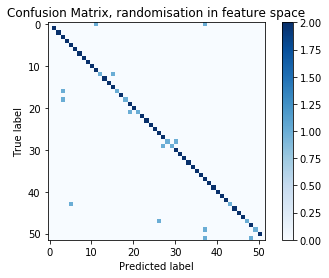

In [2]:
samples = img_idx_train
bags = []
true_lable = []
predictions = []
num_bag = 5 #number of bags
samples_per_bag = 416 # 62.3% of unique data when = N, hyperparameter
max_sample_index = np.max(img_idx_train)

eigvec_major, eigvec_residual = PCA_only(img_norm, 100)
#itemise
features = list(range(eigvec_residual.shape[1]))
max_feature_index = np.max(features)
features_per_bag = 316 # hyerparameter: M residual eigenvectors 
bags_feature = []

for i in range (num_bag): 
    bagging_pca_lda = bagging(i,features,samples, max_feature_index, max_sample_index, features_per_bag, samples_per_bag)
    feature_idx, sample_idx = bagging_pca_lda._generate_bagging_indices()
    sample_idx = np.sort(sample_idx) 
    class_idx_train = np.sort(c[:,sample_idx] -1)
    bags.append(sample_idx)
    bags_feature.append(feature_idx)
    true_lable.append(class_idx_train)

#Now LDA ensemble in feature space
M_lda=60 
img_mean = img_mean.reshape(2576, 1)
for i in range (num_bag):
    w_pca = np.append(eigvec_major,eigvec_residual[:,bags_feature[i]], axis = 1)   
    W_opt = LDA_after_PCA(w_pca, M_lda)
    recon = recognition(W_opt, img_norm, img_test)
    pred = recon._index()
    predictions.append(pred)
    
prediction_ensemble = ensemle._majority_vote(predictions)
print("accuracy after feature bagging ensemble is :%f " % ensemle._committee_score(prediction_ensemble, true_idx_test))


labels = list(set(true_idx_test.reshape(104,)))
#use sklearn
conf_mat = confusion_matrix(true_idx_test.reshape(104,), prediction_ensemble, labels = labels)
#two types of confusion matrix, one is run once, another is record 52 test faces
plot_confusion_matrix(conf_mat)
plt.title("randomisation in feature space")



In [ ]:
#-------------------------------------------------------#
for i in range (num_bag): 
    bagging_pca_lda = bagging(i,features,samples, max_feature_index, max_sample_index, features_per_bag, samples_per_bag)
    feature_idx, sample_idx = bagging_pca_lda._generate_bagging_indices()
    sample_idx = np.sort(sample_idx) 
    class_idx_train = np.sort(c[:,sample_idx] -1)
    bags.append(sample_idx)
    true_lable.append(class_idx_train)

for i in range (num_bag):
    estimator = PCA_LDA(bags[i],true_lable[i])
    W_opt = estimator._opt_components()
    recon = recognition(W_opt, img_norm, img_test)
    pred = recon._index()
    predictions.append(pred)
    
prediction_ensemble = ensemle._majority_vote(predictions)
print("accuracy after sample bagging ensemble is :%f " % ensemle._committee_score(prediction_ensemble, true_idx_test))

labels = list(set(true_idx_test.reshape(104,)))
#use sklearn
conf_mat = confusion_matrix(true_idx_test.reshape(104,), prediction_ensemble, labels = labels)
#two types of confusion matrix, one is run once, another is record 52 test faces
plot_confusion_matrix(conf_mat)
plt.title("randomisation on data samples")


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
